In [1]:
import phylustrator as ph
import phylustrator.alerax_parser as alx

In [2]:
# 1. Parse AleRax Output
# -----------------------------
path_to_alerax = "../data/alerax_output"
data = alx.parse_alerax(path_to_alerax)

# Check what we found
print(f"Loaded {len(data.events_df)} raw records.")
print("Aggregated Stats (First 5 rows):")
display(data.aggregated_stats.head())

# 2. Setup Tree
# -----------------------------
# If AleRax output provided a tree, use it. Otherwise load your reference.
if data.species_tree:
    t = data.species_tree
else:
    t = ete3.Tree("ReferenceTree.nwk")

# Convert to Ultrametric for cleaner plotting?
# t.convert_to_ultrametric() 

Loaded 1474347 raw records.
Aggregated Stats (First 5 rows):


,species_label,speciations,duplications,losses,transfers,presence,origination,copies,singletons
0,Node_species0_species3_0,273.510975,0.0,60.856494,71.758583,260.427357,0.846548,273.510975,243.653117
1,Node_species10_species19_0,264.958441,0.0,52.038024,87.492096,255.736895,14.397489,264.958441,214.698637
2,Node_species12_species0_0,274.649897,0.0,43.187716,88.324849,264.435351,11.349903,274.649897,246.619474
3,Node_species12_species16_0,279.260056,0.0,32.544655,68.867846,269.156223,3.603058,279.260056,265.636624
4,Node_species12_species20_0,260.596089,0.0,8.403911,82.228566,260.596089,269.000000,260.596089,260.596089


In [3]:
# Group by Gene Family and count unique 'replicate' values
reps_per_fam = data.events_df.groupby("gene_family")["replicate"].nunique()

print(f"Average replicates per family: {reps_per_fam.mean()}")
print(f"Max replicates per family: {reps_per_fam.max()}")
display(reps_per_fam.head())

Average replicates per family: 100.0
Max replicates per family: 100


gene_family
scaffold1030gene13    100
scaffold1030gene14    100
scaffold1030gene16    100
scaffold1030gene5     100
scaffold10973gene1    100
Name: replicate, dtype: int64

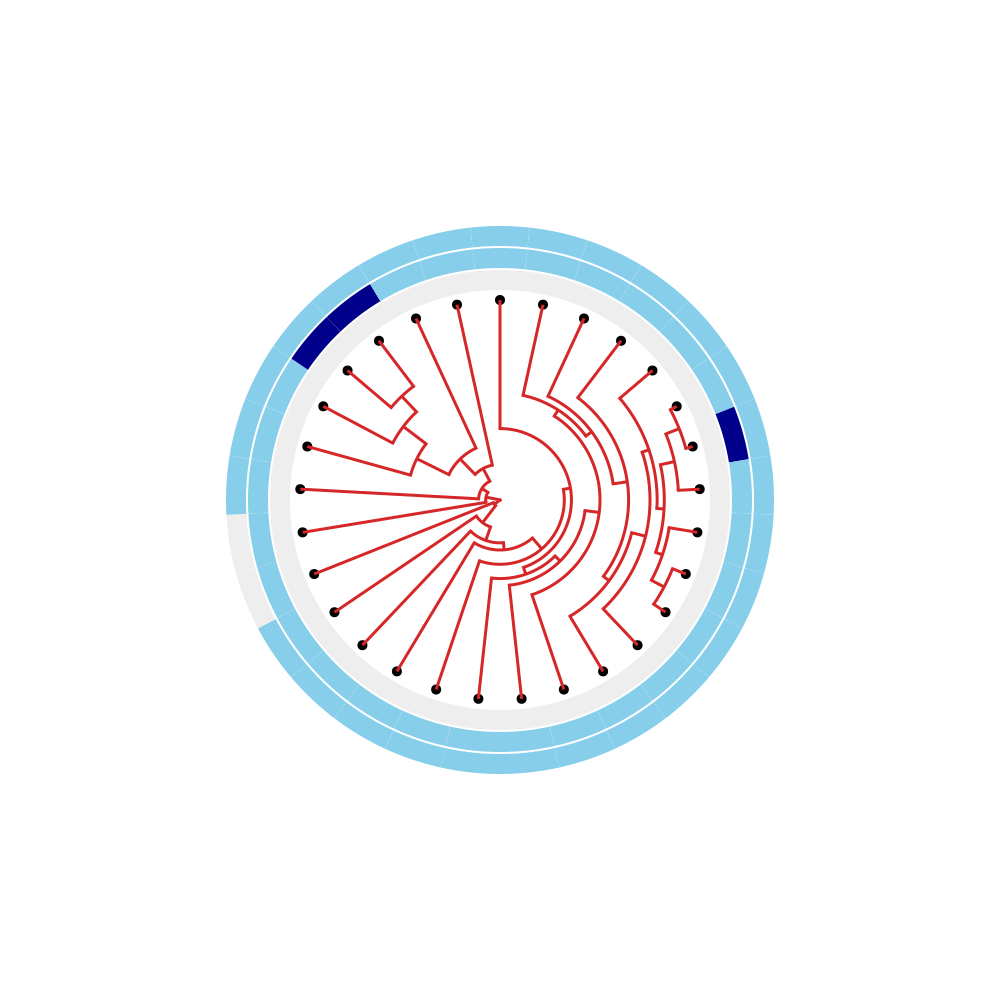

In [4]:
# 3. Setup Drawer (Renamed to RadialTreeDrawer!)
# -----------------------------
style = ph.TreeStyle(radius=200, node_size=0, branch_size=3)
drawer = ph.RadialTreeDrawer(t, style=style) # <--- Renamed class

# 4. Map Data to Colors
# -----------------------------
# We will color branches by the TOTAL number of Transfers
branch2color = {}

# Convert agg stats to dict for lookup: { 'NodeName': {'transfers': 10, ...} }
stats_map = data.aggregated_stats.set_index("species_label").to_dict(orient="index")

for n in t.traverse():
    # AleRax usually preserves node names exactly
    node_stats = stats_map.get(n.name)
    
    if node_stats:
        # Example: Log-scale coloring or threshold
        total_transfers = node_stats.get('transfers', 0)
        
        if total_transfers > 50:
            branch2color[n] = "#D62728" # Red (Hot)
        elif total_transfers > 10:
            branch2color[n] = "orange"
        else:
            branch2color[n] = "black"
    else:
        branch2color[n] = "grey"

# 5. Draw
# -----------------------------
drawer.draw(branch2color=branch2color)

# 6. Add Heatmap of Duplications/Losses
# -----------------------------
# Extract leaf data for the matrix
heatmap_data = {}
for l in t.get_leaves():
    s = stats_map.get(l.name)
    if s:
        heatmap_data[l.name] = {
            "D": s['duplications'],
            "L": s['losses'],
            "T": s['transfers']
        }

def heat_cmap(val):
    if val > 100: return "darkblue"
    if val > 20: return "skyblue"
    return "#eee"

drawer.add_heatmap_matrix(heatmap_data, columns=["D", "T", "L"], cmap=heat_cmap)
display(drawer.d)